# Zone axis alignment

In this notebook, we will calculate the necessary angles to tilt the sample such that a given zone axis is aligned with the optical axis.

In [1]:
# Import the necessary packages
%matplotlib inline
from orix.vector import Vector3d, Miller
import numpy as np

from tiltlib import Axis, Sample

## Load data

We use Orix's austenite crystal map, and a double-tilt sample holder with axes offset by 30 degrees to the scan.

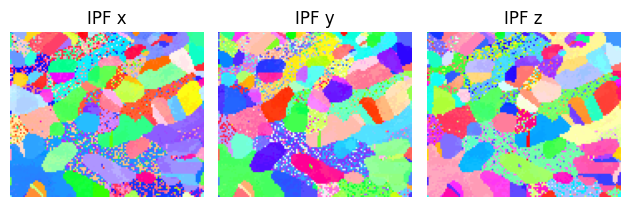

In [2]:
from orix.data import sdss_austenite

# This is the raw data we will use
raw_xmap = sdss_austenite(allow_download=True)

# Define the tilt axes of the sample holder.
# If these are not known, refer to the `tilt_axis_identification.ipynb` example notebook.
x_tilt_axis = Axis(
    Vector3d.xvector().rotate(Vector3d.zvector(), np.deg2rad(30)),
    min=-30, 
    max=30,
    angle=0,
    intrinsic=False,
)
y_tilt_axis = Axis(
    Vector3d.yvector().rotate(Vector3d.zvector(), np.deg2rad(30)),
    min=-30, 
    max=30,
    angle=0,
    intrinsic=True,
) 

# Initialize the sample object
sample = Sample.from_crystal_map(raw_xmap, [x_tilt_axis, y_tilt_axis])

figure = sample.plot()

If you have your own data, replace the axes and crystal map with your own. Remember to assign the correct initial tilt angles to the axes.

## Grain selection

We choose a grain as a target for our optimization with a hyperspy ROI.
Both a box ROI and a circle ROI are supported, but we only show the rectangular ROI.

<Signal2D, title: , dimensions: (|11, 6)>

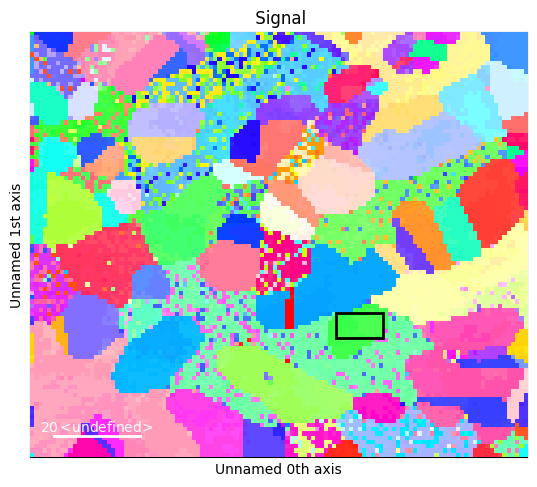

In [3]:
# For example purposes, we have used %matplotlib inline. This makes the plot static.
# For an interactive experience, use e.g. %matplotlib qt5

# Make a navigation signal, to have an interactive ROI.
nav = sample.to_navigator()
nav.plot()

from hyperspy.roi import RectangularROI

box = RectangularROI(left=72, top=66, right=83, bottom=72)
box.interactive(nav, color="black")

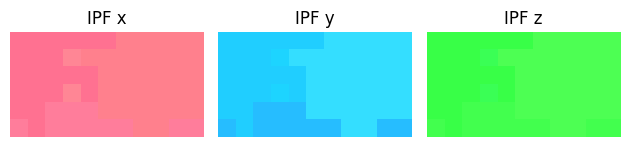

In [4]:
box_crop = sample.crop(box)
fig = box_crop.plot()

The chosen grain is quite close to [1 0 1]. Next, we will try to align it to that zone axis.

## Find the tilt angles

Now, we choose a miller index, here [1 0 1], and find the angles necessary for aligning the grain to that zone axis.

In [5]:
target = Miller(uvw=[1, 0, 1], phase=sample.phase)

# This is a uniform grain; we can speed up calculations by setting
# `use_mean_orientation`.
box_angles = box_crop.find_tilt_angles(target, use_mean_orientation=True)
print(f"{box_angles = } degrees")

box_angles = array([0.41907898, 5.89399747]) degrees


In [6]:
box_crop.rotate_to(*box_angles, degrees=True)
box_crop.mean_zone_axis()

Miller (1,), point group m-3m, uvw
[[ 0. -1.  1.]]

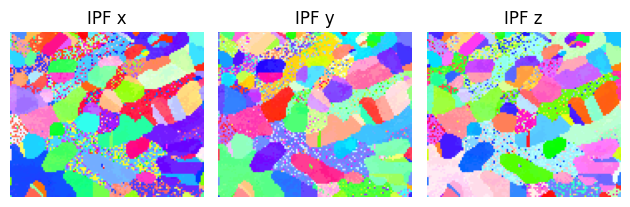

In [7]:
sample.rotate_to(*box_angles, degrees=True)
figure = sample.plot()

The grain we chose is indeed close to [1 0 1], as expected, and the necessary tilt angles are small.

## Twin alignment

Next, we will try to align two twin grains to the same zone simultaneously.

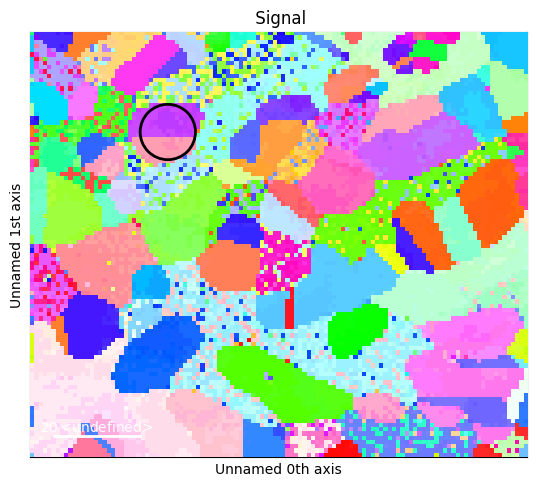

In [8]:
nav = sample.to_navigator()
nav.plot()

from hyperspy.roi import CircleROI

circle = CircleROI(cx=32, cy=23, r=7, r_inner=0)

# Ignore an error which does not affect us
try:
    circle.interactive(nav, color="black")
except np.exceptions.DTypePromotionError:
    pass


These $\Sigma3$ twins should share a $\left[1\,0\,1\right]$ zone

In [9]:
circle_crop = sample.crop(circle)
target = Miller(uvw=[1, 0, 1], phase=sample.phase)

# Important: use_mean_orientation must be False (default)
# else, the optimization would use the mean orientation, 
# which is NOT representative of the two orientation populations
circle_angles = circle_crop.find_tilt_angles(target, use_mean_orientation=False)
print(f"{circle_angles = } degrees")

circle_angles = array([-12.86982252, -17.73283528]) degrees


In [10]:
circle_crop.rotate_to(*circle_angles, degrees=True)
circle_crop.mean_zone_axis()

Miller (1,), point group m-3m, uvw
[[1. 0. 1.]]

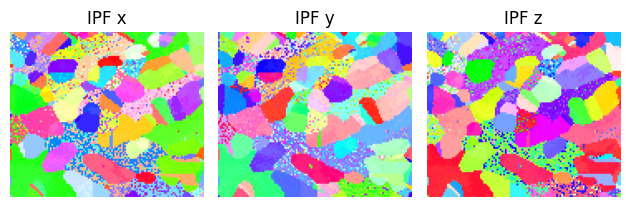

In [11]:
sample.rotate_to(*circle_angles, degrees=True)
fig = sample.plot()

We see that both grains indeed align simultaneously.